# First implementation of a multi-zone building thermal simulation


## CAS SANS ECHANGE INTER ZONE

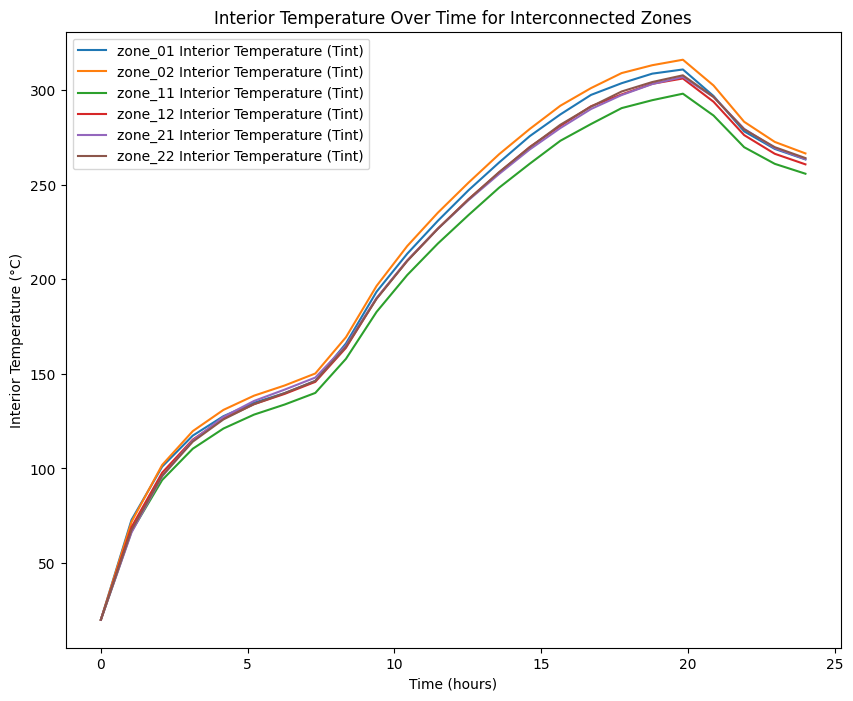

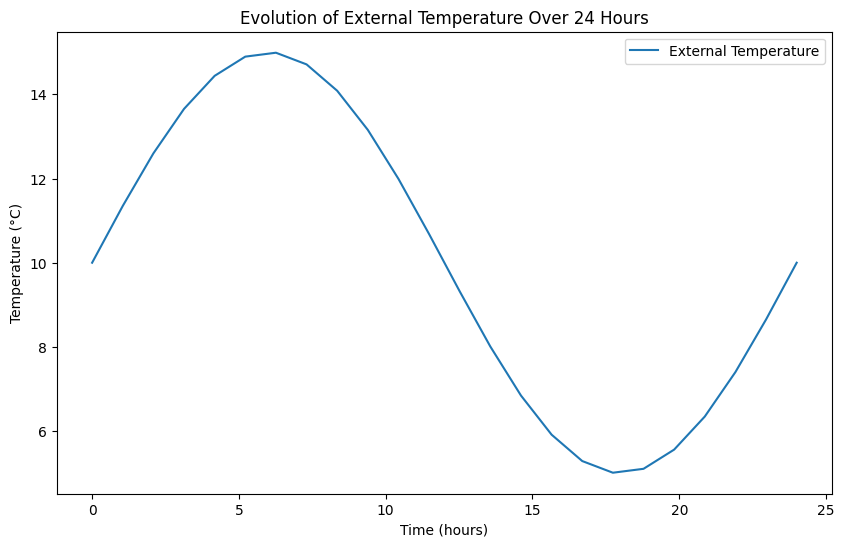

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Define the MultiZoneRCModel class for each zone
class MultiZoneRCModel:
    def __init__(self, zone_name, Ri, Ro, Rf, Cs, Cres, initial_temp=20):
        """
        Parameters:
        - zone_name: Name of the zone
        - Ri, Ro, Rf: Resistances for internal wall, outer wall, and window
        - Cs, Cres: Capacitances for the wall and the room air
        - initial_temp: Initial temperature inside the zone
        """
        self.zone_name = zone_name
        self.Ri = Ri
        self.Ro = Ro
        self.Rf = Rf
        self.Cs = Cs
        self.Cres = Cres
        self.initial_temp = initial_temp
        self.neighbors = []  # List of tuples (neighbor_zone, resistance_between_zones)

        # Time-varying parameters
        self.external_temp_series = None
        self.solar_gain_series = None
        self.internal_gain_series = None

    def set_time_series(self, time_points, external_temp, solar_gain, internal_gain):
        """
        Set time-dependent series for external temperature, solar gain, and internal gain.
        """
        self.external_temp_series = interp1d(time_points, external_temp, kind='linear', fill_value='extrapolate')
        self.solar_gain_series = interp1d(time_points, solar_gain, kind='linear', fill_value='extrapolate')
        self.internal_gain_series = interp1d(time_points, internal_gain, kind='linear', fill_value='extrapolate')

    def add_neighbor(self, neighbor_zone, thermal_resistance):
        """
        Add a neighboring zone and the thermal resistance to that neighbor.
        """
        self.neighbors.append((neighbor_zone, thermal_resistance))

    def thermal_dynamics(self, t, y, all_zones_temp):
        """
        Defines differential equations with thermal exchange between zones.
        """
        Ts, Tint = y

        # Time-dependent values
        external_temp = self.external_temp_series(t)
        solar_gain = self.solar_gain_series(t)
        internal_gain = self.internal_gain_series(t)

        # Calculate the thermal exchange with neighboring zones
        neighbor_exchange = sum(
            (all_zones_temp[neighbor.zone_name] - Tint) / R_ij
            for neighbor, R_ij in self.neighbors
        )

        # Differential equations with thermal exchange
        dTs_dt = (1 / self.Cs) * ((Tint - Ts) / self.Ri - (Ts - external_temp) / self.Ro + solar_gain)
        dTint_dt = (1 / self.Cres) * ((Ts - Tint) / self.Ri + (external_temp - Tint) / self.Rf + internal_gain + neighbor_exchange)
        return [dTs_dt, dTint_dt]

# Initialize time points and varying parameters
time_points = np.linspace(0, 24 * 3600, 24)
external_temp_values = 10 + 5 * np.sin(2 * np.pi * time_points / (24 * 3600))
solar_gain_values = np.clip(500 * np.sin(2 * np.pi * (time_points - 6 * 3600) / (24 * 3600)), 0, None)
internal_gain_values = 200 + 100 * ((time_points % (24 * 3600)) > 8 * 3600) * ((time_points % (24 * 3600)) < 20 * 3600)

# Create 6 interconnected zones in 3 stages
zones = {
    "zone_01": MultiZoneRCModel("zone_01", Ri=0.8, Ro=1.5, Rf=2.0, Cs=1e5, Cres=1e4),
    "zone_02": MultiZoneRCModel("zone_02", Ri=0.9, Ro=1.4, Rf=2.1, Cs=1e5, Cres=1.1e4),
    "zone_11": MultiZoneRCModel("zone_11", Ri=0.7, Ro=1.6, Rf=1.9, Cs=1.2e5, Cres=1.2e4),
    "zone_12": MultiZoneRCModel("zone_12", Ri=0.85, Ro=1.5, Rf=2.0, Cs=1.1e5, Cres=1.15e4),
    "zone_21": MultiZoneRCModel("zone_21", Ri=0.9, Ro=1.7, Rf=2.3, Cs=1.3e5, Cres=1.3e4),
    "zone_22": MultiZoneRCModel("zone_22", Ri=0.8, Ro=1.6, Rf=2.2, Cs=1.15e5, Cres=1.2e4),
}

# Set time series for each zone
for zone in zones.values():
    zone.set_time_series(time_points, external_temp_values, solar_gain_values, internal_gain_values)

# Define thermal resistances between zones in the 3x2 structure
zones["zone_01"].add_neighbor(zones["zone_02"], thermal_resistance=1.0)
zones["zone_02"].add_neighbor(zones["zone_01"], thermal_resistance=1.0)

zones["zone_11"].add_neighbor(zones["zone_12"], thermal_resistance=1.0)
zones["zone_12"].add_neighbor(zones["zone_11"], thermal_resistance=1.0)

zones["zone_21"].add_neighbor(zones["zone_22"], thermal_resistance=1.0)
zones["zone_22"].add_neighbor(zones["zone_21"], thermal_resistance=1.0)

# Vertical connections between stages
zones["zone_01"].add_neighbor(zones["zone_11"], thermal_resistance=1.5)
zones["zone_11"].add_neighbor(zones["zone_01"], thermal_resistance=1.5)

zones["zone_02"].add_neighbor(zones["zone_12"], thermal_resistance=1.5)
zones["zone_12"].add_neighbor(zones["zone_02"], thermal_resistance=1.5)

zones["zone_11"].add_neighbor(zones["zone_21"], thermal_resistance=1.5)
zones["zone_21"].add_neighbor(zones["zone_11"], thermal_resistance=1.5)

zones["zone_12"].add_neighbor(zones["zone_22"], thermal_resistance=1.5)
zones["zone_22"].add_neighbor(zones["zone_12"], thermal_resistance=1.5)

# Combined dynamics function
def combined_dynamics(t, y):
    all_zones_temp = {}
    index = 0
    for zone_name, zone in zones.items():
        Ts, Tint = y[index], y[index + 1]
        all_zones_temp[zone_name] = Tint
        index += 2
    
    dydt = []
    index = 0
    for zone_name, zone in zones.items():
        Ts, Tint = y[index], y[index + 1]
        dTs_dt, dTint_dt = zone.thermal_dynamics(t, [Ts, Tint], all_zones_temp)
        dydt.extend([dTs_dt, dTint_dt])
        index += 2
    return dydt

# Initial conditions for each zone's Ts and Tint
initial_conditions = []
for zone in zones.values():
    initial_conditions.extend([zone.initial_temp, zone.initial_temp])

# Simulate over 24 hours
time_span = (0, 24 * 3600)
time_eval = np.linspace(time_span[0], time_span[1], 24)

# Run the simulation
solution = solve_ivp(combined_dynamics, time_span, initial_conditions, t_eval=time_eval)

# Plot interior temperature for each zone
plt.figure(figsize=(10, 8))
for i, (zone_name, zone) in enumerate(zones.items()):
    Tint = solution.y[i * 2 + 1]  # Extract Tint for each zone
    plt.plot(solution.t / 3600, Tint, label=f"{zone_name} Interior Temperature (Tint)")

plt.xlabel("Time (hours)")
plt.ylabel("Interior Temperature (°C)")
plt.title("Interior Temperature Over Time for Interconnected Zones")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_points / 3600, external_temp_values, label="External Temperature")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.title("Evolution of External Temperature Over 24 Hours")
plt.legend()
plt.show()


## IMPORT et def class

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Define the MultiZoneRCModel class for each zone
class MultiZoneRCModel:
    def __init__(self, zone_name, Ri, Ro, Rf, Cs, Cres, initial_temp=20):
        """
        Parameters:
        - zone_name: Name of the zone
        - Ri, Ro, Rf: Resistances for internal wall, outer wall, and window
        - Cs, Cres: Capacitances for the wall and the room air
        - initial_temp: Initial temperature inside the zone
        """
        self.zone_name = zone_name
        self.Ri = Ri
        self.Ro = Ro
        self.Rf = Rf
        self.Cs = Cs
        self.Cres = Cres
        self.initial_temp = initial_temp
        self.neighbors = []  # List of tuples (neighbor_zone, resistance_between_zones)

        # Time-varying parameters
        self.external_temp_series = None
        self.solar_gain_series = None
        self.internal_gain_series = None

    def set_time_series(self, time_points, external_temp, solar_gain, internal_gain):
        """
        Set time-dependent series for external temperature, solar gain, and internal gain.
        """
        self.external_temp_series = interp1d(time_points, external_temp, kind='linear', fill_value='extrapolate')
        self.solar_gain_series = interp1d(time_points, solar_gain, kind='linear', fill_value='extrapolate')
        self.internal_gain_series = interp1d(time_points, internal_gain, kind='linear', fill_value='extrapolate')

    def add_neighbor(self, neighbor_zone, thermal_resistance):
        """
        Add a neighboring zone and the thermal resistance to that neighbor.
        """
        self.neighbors.append((neighbor_zone, thermal_resistance))

    def thermal_dynamics(self, t, y, all_zones_temp):
        """
        Defines differential equations with thermal exchange between zones.
        """
        Ts, Tint = y

        # Time-dependent values
        external_temp = self.external_temp_series(t)
        solar_gain = self.solar_gain_series(t)
        internal_gain = self.internal_gain_series(t)

        # Calculate the thermal exchange with neighboring zones
        neighbor_exchange = sum(
            (all_zones_temp[neighbor.zone_name] - Tint) / R_ij
            for neighbor, R_ij in self.neighbors
        )

        # Differential equations with thermal exchange
        dTs_dt = (1 / self.Cs) * ((Tint - Ts) / self.Ri - (Ts - external_temp) / self.Ro + solar_gain)
        dTint_dt = (1 / self.Cres) * ((Ts - Tint) / self.Ri + (external_temp - Tint) / self.Rf + internal_gain + neighbor_exchange)
        return [dTs_dt, dTint_dt]

## INIT ET CALCUL

In [ ]:


# Initialize time points and varying parameters for 10 days
time_points = np.linspace(0, 10 * 24 * 3600, 10 * 24)
external_temp_value = 10 + 5 * np.sin(2 * np.pi * time_points / (24 * 3600))
solar_gain_values = np.clip(1000 * np.sin(2 * np.pi * (time_points - 6 * 3600) / (24 * 3600)), 0, None)

# Define different internal gain profiles for each zone
internal_gain_profiles = {
    "zone_01": 10 + 1 * ((time_points % (24 * 3600)) > 8 * 3600) * ((time_points % (24 * 3600)) < 20 * 3600),
    "zone_02": 10 + 1 * ((time_points % (24 * 3600)) > 9 * 3600) * ((time_points % (24 * 3600)) < 18 * 3600),
    "zone_11": 10 + 1 * ((time_points % (24 * 3600)) > 7 * 3600) * ((time_points % (24 * 3600)) < 21 * 3600),
    "zone_12": 10 + 1 * ((time_points % (24 * 3600)) > 6 * 3600) * ((time_points % (24 * 3600)) < 22 * 3600),
    "zone_21": 10 + 1 * ((time_points % (24 * 3600)) > 5 * 3600) * ((time_points % (24 * 3600)) < 19 * 3600),
    "zone_22": 10 + 1 * ((time_points % (24 * 3600)) > 8 * 3600) * ((time_points % (24 * 3600)) < 20 * 3600),
}

# Create 6 interconnected zones in 3 stages
zones = {
    "zone_01": MultiZoneRCModel("zone_01",   Ri=10000.8, Ro=10000.5, Rf=20.0, Cs=1e8, Cres=2e2),
    "zone_02": MultiZoneRCModel("zone_02",   Ri=10000.8, Ro=10000.5, Rf=20.0, Cs=1e8, Cres=2e2),
    "zone_11": MultiZoneRCModel("zone_11",   Ri=10000.8, Ro=10000.5, Rf=20.0, Cs=1e8, Cres=2e2),
    "zone_12": MultiZoneRCModel("zone_12",   Ri=10000.8, Ro=10000.5, Rf=20.0, Cs=1e8, Cres=2e2),
    "zone_21": MultiZoneRCModel("zone_21",   Ri=10000.8, Ro=10000.5, Rf=20.0, Cs=1e8, Cres=2e2),
    "zone_22": MultiZoneRCModel("zone_22",   Ri=10000.8, Ro=10000.5, Rf=20.0, Cs=1e8, Cres=2e2),
}

# Set time series for each zone
for zone_name, zone in zones.items():
    # Set the internal gain for each zone based on its respective profile
    internal_gain = internal_gain_profiles[zone_name]
    zone.set_time_series(time_points, external_temp_values, solar_gain_values, internal_gain)

# Define thermal resistances between zones in the 3x2 structure
zones["zone_01"].add_neighbor(zones["zone_02"], thermal_resistance=1000000.0)
zones["zone_02"].add_neighbor(zones["zone_01"], thermal_resistance=1000000.0)

zones["zone_11"].add_neighbor(zones["zone_12"], thermal_resistance=1000000.0)
zones["zone_12"].add_neighbor(zones["zone_11"], thermal_resistance=1000000.0)

zones["zone_21"].add_neighbor(zones["zone_22"], thermal_resistance=1000000.0)
zones["zone_22"].add_neighbor(zones["zone_21"], thermal_resistance=1000000.0)

# Vertical connections between stages
zones["zone_01"].add_neighbor(zones["zone_11"], thermal_resistance=1000000.5)
zones["zone_11"].add_neighbor(zones["zone_01"], thermal_resistance=1000000.5)

zones["zone_02"].add_neighbor(zones["zone_12"], thermal_resistance=1000000.5)
zones["zone_12"].add_neighbor(zones["zone_02"], thermal_resistance=1000000.5)

zones["zone_11"].add_neighbor(zones["zone_21"], thermal_resistance=1000000.5)
zones["zone_21"].add_neighbor(zones["zone_11"], thermal_resistance=1000000.5)

zones["zone_12"].add_neighbor(zones["zone_22"], thermal_resistance=1000000.5)
zones["zone_22"].add_neighbor(zones["zone_12"], thermal_resistance=1000000.5)

In [57]:
# Combined dynamics function
def combined_dynamics(t, y):
    all_zones_temp = {}
    index = 0
    for zone_name, zone in zones.items():
        Ts, Tint = y[index], y[index + 1]
        all_zones_temp[zone_name] = Tint
        index += 2
    
    dydt = []
    index = 0
    for zone_name, zone in zones.items():
        Ts, Tint = y[index], y[index + 1]
        dTs_dt, dTint_dt = zone.thermal_dynamics(t, [Ts, Tint], all_zones_temp)
        dydt.extend([dTs_dt, dTint_dt])
        index += 2
    return dydt

# Initial conditions for each zone's Ts and Tint
initial_conditions = []
for zone in zones.values():
    initial_conditions.extend([zone.initial_temp, zone.initial_temp])

# Simulate over 10 days
time_span = (0, 10 * 24 * 3600)
time_eval = np.linspace(time_span[0], time_span[1], 10 * 24)

# Run the simulation
solution = solve_ivp(combined_dynamics, time_span, initial_conditions, t_eval=time_eval)

## PLOT

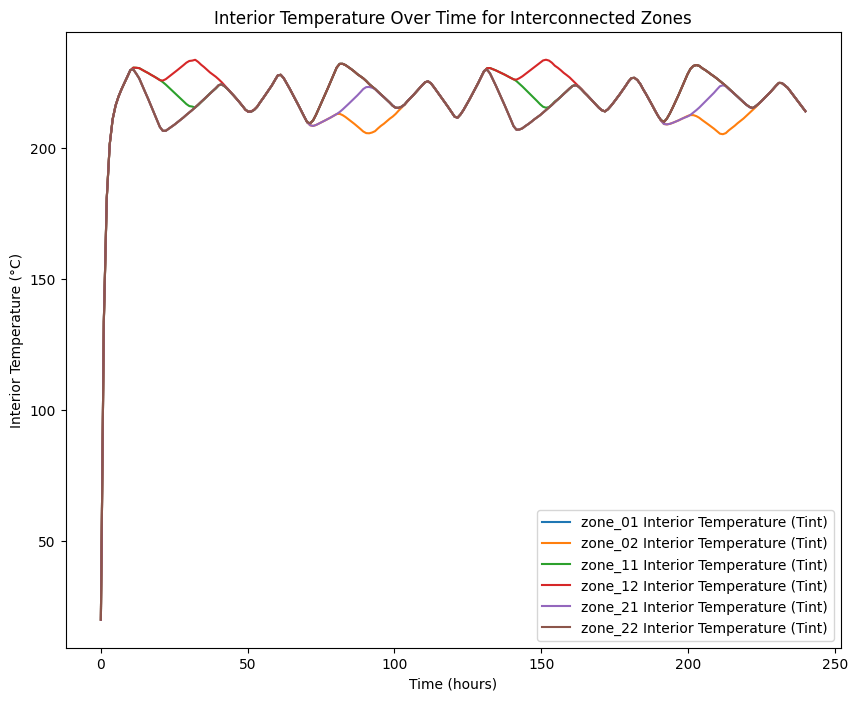

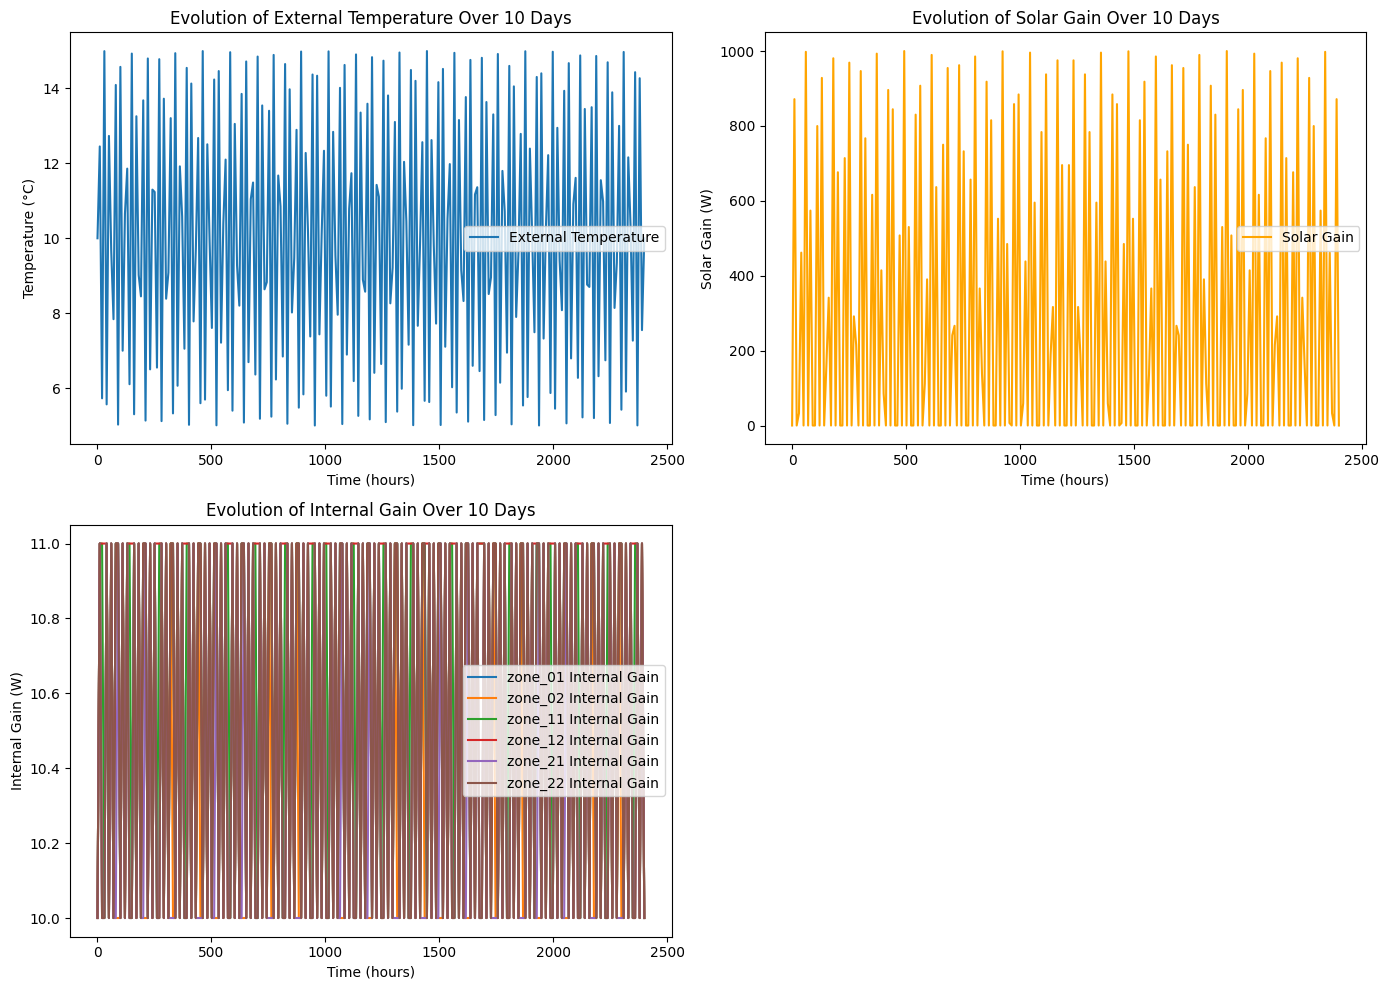

In [58]:
# Plot interior temperature for each zone
plt.figure(figsize=(10, 8))
for i, (zone_name, zone) in enumerate(zones.items()):
    Tint = solution.y[i * 2 + 1]  # Extract Tint for each zone
    plt.plot(solution.t / 3600, Tint, label=f"{zone_name} Interior Temperature (Tint)")
plt.xlabel("Time (hours)")
plt.ylabel("Interior Temperature (°C)")
plt.title("Interior Temperature Over Time for Interconnected Zones")
plt.legend()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot external temperature
axs[0, 0].plot(time_points / 3600, external_temp_values, label="External Temperature")
axs[0, 0].set_xlabel("Time (hours)")
axs[0, 0].set_ylabel("Temperature (°C)")
axs[0, 0].set_title("Evolution of External Temperature Over 10 Days")
axs[0, 0].legend()

# Plot solar gain
axs[0, 1].plot(time_points / 3600, solar_gain_values, label="Solar Gain", color='orange')
axs[0, 1].set_xlabel("Time (hours)")
axs[0, 1].set_ylabel("Solar Gain (W)")
axs[0, 1].set_title("Evolution of Solar Gain Over 10 Days")
axs[0, 1].legend()

# Plot internal gain for each zone
for zone_name, internal_gain in internal_gain_profiles.items():
    axs[1, 0].plot(time_points / 3600, internal_gain, label=f"{zone_name} Internal Gain")

axs[1, 0].set_xlabel("Time (hours)")
axs[1, 0].set_ylabel("Internal Gain (W)")
axs[1, 0].set_title("Evolution of Internal Gain Over 10 Days")
axs[1, 0].legend()

# Hide the empty subplot
fig.delaxes(axs[1, 1])

plt.tight_layout()
plt.show()
